<h2> Classifying cat and dog image data using pretrained VGG19. </h2>


<h2></h2> <img src =" https://cdn-images-1.medium.com/max/1600/1*cufAO77aeSWdShs3ba5ndg.jpeg"> 


In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

In [0]:
#importing the necessary libraries
import torch
import torchvision
import cv2
from torchvision import models
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import copy
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import PIL
import os,sys,time
%matplotlib inline

In [0]:
#interactive mode

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [0]:
#uploading the files from local disk

from google.colab import files
files = files.upload()

Saving valid.zip to valid.zip


In [0]:
#extracting the zip file

import io
import zipfile
zip_ref = zipfile.ZipFile("train.zip","r")
zip_ref.extractall()
zip_ref.close()


In [0]:
zip_ref = zipfile.ZipFile("valid.zip","r")
zip_ref.extractall()
zip_ref.close()

In [0]:
!ls

sample_data  train  train.zip  valid  valid.zip


In [0]:
!pwd

/content


In [0]:
# train images path 
train = "/content/train"
#test images path
test = "/content/valid"

In [0]:
class Cat_Dog(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.files = os.listdir(root_dir)
    self.img_lab={}
    for f in self.files:
      label = f.split('.')[0]
      self.img_lab[f] = label
    files = pd.Series(self.img_lab)
    self.labels,_ = files.factorize()
    self.transform = transform
  def __len__(self):
    return len(self.files)
  def __getitem__(self, idx):
    img = self.files[idx]
    label = self.labels[idx]
    image = PIL.Image.open(os.path.join(self.root_dir, img))
    if self.transform:
      image=self.transform(image)
    return image, label

In [0]:
train_data = Cat_Dog(train, transform=torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), torchvision.transforms.ToTensor()]))

In [0]:
test_data = Cat_Dog(test, transform=torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), torchvision.transforms.ToTensor()]))

In [0]:
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [0]:
img, label = next(iter(train_loader))


 0
[torch.LongTensor of size 1]



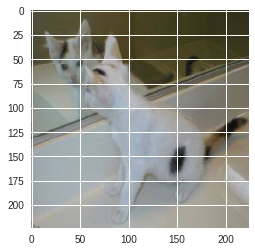

In [0]:
plt.imshow(img[0].permute(1,2,0))
print(label)
no_classes = 2

In [0]:
#loading the pretrained Vgg19 with batch normalization model from the torchvision library
vgg19 = models.vgg19_bn(pretrained=True)


In [0]:
print(vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (7): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (14): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (16): ReLU(inplace)
   

In [0]:
# Freeze training for all layers
for param in vgg19.features.parameters():
    param.require_grad = False

In [0]:
# Newly created modules have require_grad=True by default
num_features = vgg19.classifier[6].in_features
features = list(vgg19.classifier.children())[:-2] # Remove last two layer
features.extend([nn.Linear(num_features, 4096)])
features.extend([nn.Linear(4096, no_classes)]) # Add our layer with 2 outputs
vgg19.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (7): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (14): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (16): ReLU(inplace)
   

In [0]:
if use_gpu:
    vgg19.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(vgg19.parameters(), lr=0.001, momentum=0.9)

In [0]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(test_loader)
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(test_loader):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_loader), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data[0]
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / len(test_loader)
    avg_acc = acc_test / len(test_loader)
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [0]:
print("Test before training")
eval_model(vgg19, criterion)

Test before training
Evaluating model
----------
Test batch 0/<torch.utils.data.dataloader.DataLoader object at 0x7f852265d7f0>
Evaluation completed in 0m 1s
Avg loss (test): 0.7355
Avg acc (test): 0.3750
----------


In [0]:
def train_model(vgg, criterion, optimizer, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(train_loader)
    val_batches = len(test_loader)
 
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(train_loader):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            if i >= train_batches / 2:
                break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data[0]
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / len(train_loader)
        avg_acc = acc_train * 2 / len(train_loader)
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(test_loader):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data[0]
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / len(test_loader)
        avg_acc_val = acc_val / len(test_loader)
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [0]:
vgg19 = train_model(vgg19, criterion, optimizer_ft, num_epochs=25)

Epoch 0/25
----------
Training batch 0/25.0
Validation batch 0/24
Epoch 0 result: 
Avg loss (train): 0.8032
Avg acc (train): 0.5200
Avg loss (val): 1.0686
Avg acc (val): 0.4583
----------

Epoch 1/25
----------
Training batch 0/25.0
Validation batch 0/24
Epoch 1 result: 
Avg loss (train): 0.7458
Avg acc (train): 0.5600
Avg loss (val): 0.8831
Avg acc (val): 0.3750
----------

Epoch 2/25
----------
Training batch 0/25.0
Validation batch 0/24
Epoch 2 result: 
Avg loss (train): 0.4444
Avg acc (train): 0.8000
Avg loss (val): 1.1756
Avg acc (val): 0.3333
----------

Epoch 3/25
----------
Training batch 0/25.0
Validation batch 0/24
Epoch 3 result: 
Avg loss (train): 0.0788
Avg acc (train): 1.0000
Avg loss (val): 1.5004
Avg acc (val): 0.4167
----------

Epoch 4/25
----------
Training batch 0/25.0
Validation batch 0/24
Epoch 4 result: 
Avg loss (train): 0.0981
Avg acc (train): 0.9600
Avg loss (val): 1.3905
Avg acc (val): 0.2917
----------

Epoch 5/25
----------
Training batch 0/25.0
Validation 